# Document Setup

- Project ID: EMB_ex14
- Researchers: DK
- Current Version: v1.2.1

See associated protocol for more details.

In [1]:
# Stdlib
import sys
import os
import random
from IPython.display import display, Latex

# Scientific computing
import numpy as np
from node2vec import Node2Vec as N2V

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

# Experiment

## Preface

**Goal**

Explore fundamental differences in link prediction and multiplex reconstruction setting on uncorrelated ring topologies.

**Procedure**

1. Generate a ring network, $G$.
2. Create a deepcopy of $G$, $H$, and shuffle the node labels of $H$.
3. Aggregate $G, H$; call it $A$
4. Observe some partial observations from $A$; call them $\theta_G, \theta_H$
5. Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$
6. Embed $R_G, R_H$; call them $E_G, E_H$
7. Select some edge, $e = (i,j) \in A$
8. Calculate $d_G = d_{E_G}(i, j), d_H = d_{E_H}(i, j)$
9. Repeat (7), (8) for all edges $e \in A$
10. Examine resultant distribution of $d$

## Prerequisite code

In [2]:
def generate_ring_duplex(number_of_nodes):
    """
    Generate a duplex of rings with one layer having shuffled node labels of the other.
    """
    # Create one layer, a ring network
    G = nx.cycle_graph(number_of_nodes)

    # Independent shallow copy the layer
    # * Note that node and edge attributes may have correlations - for this experiment, does not matter but it may in the future
    H = G.copy()

    # Shuffle H's nodes
    new_labels = list(H.nodes())
    random.shuffle(new_labels)  # ^ Why is there such a mix of in-place functions and not :,(
    relabeling_mapping = {node: new_labels[node] for node in range(H.number_of_nodes())}
    H = nx.relabel_nodes(H, relabeling_mapping)

    # ? Do I need to remove any still existing overlap? That would cause disconnectedness necessarily (if overlap is present)

    return G, H

In [3]:
def get_representation(G, params):
    """
    Embed a monoplex with node2vec. Wrapper from @Minsuk Kim.
    """
    # Unpack parameters
    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    # Create node2vec model
    n2v = N2V(G,
        dimensions = dimensions,
        walk_length = walk_length,
        num_walks = num_walks,
        workers = workers,
        quiet = True,
    )

    # Embed topology under specified n2v model
    embedding = n2v.fit(window = window,
        min_count = min_count,
        batch_words = batch_words,
    )

    # Format resultant vectors
    # * Output format: Array with row [i] corresponding to embedded vector of node i
    representation = np.array([
        embedding.wv['%d'%i]
        for i in range(G.number_of_nodes())
    ])

    return representation

In [4]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

## Workflow

In [5]:
# * Experiment Parameters
# >>> Network topology <<<
N = 100  # size of rings

# >>> Node2Vec embedding <<<
dimensions = 100  # euclidean dimension to embedd
walk_length = 30  # number of nodes in each walk
num_walks = 100  # number of walks per node
workers = 10  # for cpu parallel work
window = 10  # maximum distance between the current and predicted word within a sentence.
min_count = 1  # ignores all words with total frequency lower than this
batch_words = 4  # [unsure]
params = [dimensions, walk_length, num_walks, workers, window, min_count, batch_words]

# >>> Other <<<
repeat = 100  # number of simulations

In [6]:
# * Steps (1), (2) - Get desired duplex
G, H = generate_ring_duplex(100)

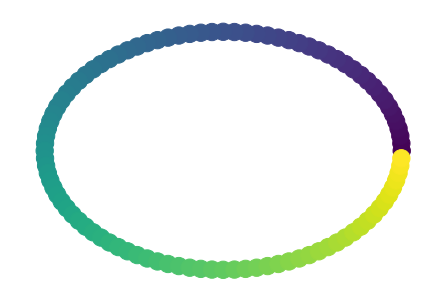

In [7]:
nx.draw(G, node_color=range(N), pos=nx.circular_layout(G))

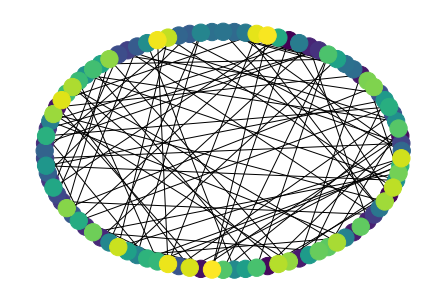

In [8]:
nx.draw(H, node_color=range(N), pos=nx.circular_layout(G))

### Multiple $\theta$

In [9]:
delta_theta = 0.02
theta_start = 0.02
theta_end = 0.98
thetas = np.arange(theta_start, theta_end + delta_theta, step=delta_theta)  # partial fraction of information
distances_sweep = {}

In [293]:
for theta in tqdm(thetas):
    # * Steps (3) thru (5) - Observe a priori information and calculate remnants
    R_G, R_H, A = utils.partial_information(G, H, theta)

    # * Step (6) - Embed remnants
    E_G = get_representation(R_G, params)
    E_H = get_representation(R_H, params)

    # * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
    distances = {}
    for edge in A.keys():
        d = calculate_distances(edge, E_G, E_H)
        distances[edge] = d

    distances_sweep[theta] = distances

100%|██████████| 49/49 [27:51<00:00, 34.11s/it]


### Single $\theta$

In [10]:
theta = 0.5

In [18]:
# * Steps (3) thru (5) - Observe a priori information and calculate remnants
R_G, R_H, A = utils.partial_information(G, H, theta)

In [19]:
# * Step (6) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [20]:
# * Steps (7) thru (9) - Calculate distances of nodes incident to edges in both embeddings
distances_single = {}
for edge in tqdm(A.keys()):
    d = calculate_distances(edge, E_G, E_H)
    distances_single[edge] = d

  0%|          | 0/109 [00:00<?, ?it/s]

## Analysis

### Processing and cleanup

In [21]:
# Single theta
d_G = [d[0] for d in distances_single.values()]
d_H = [d[1] for d in distances_single.values()]

In [22]:
# Single theta component analysis
## Build graph of test set
A_single = nx.Graph()
A_single.add_nodes_from(range(N))
for edge in distances_single.keys():
    A_single.add_edge(*edge)

## Retrieve components (by edges)
A_single_components = [A_single.subgraph(c).copy().edges() for c in nx.connected_components(A_single)]

In [23]:
# Multiple theta
filepath_df = "../../results/dataframes/dataframe_EMB_ex14v1.2_DK_20221231.csv"
filepath_df_melted = "../../results/dataframes/dataframe-melted_EMB_ex14v1.2_DK_20221231.csv"

if os.path.exists(filepath_df) and os.path.exists(filepath_df_melted):
    df = pd.read_csv(filepath_df)
    df_melted = pd.read_csv(filepath_df_melted)
else:
    records = []
    for theta, distances in distances_sweep.items():
        for edge, d in distances.items():
            if edge not in A:
                edge = edge[::-1]

            record = {
                "theta": theta,
                "d_G": d[0],
                "d_H": d[1],
                "edge": edge,
                "ground_truth_aprx": 1 if ((edge[0] == edge[1]+1) or (edge[1] == edge[0]+1)) else 0,
                "classification": int(d[0] <= d[1]),
            }
            records.append(record)

    df = pd.DataFrame.from_records(records)
    df["correct"] = df["ground_truth_aprx"] == df["classification"]
    df["inverse"] = (1/df["d_G"]) / ((1/df["d_G"]) + (1/df["d_H"]))
    df["negexp"] = np.exp(-df["d_G"]) / (np.exp(-df["d_G"]) + np.exp(-df["d_H"]))

    df_melted = pd.melt(df, id_vars=["theta", "edge", "inverse", "negexp", "correct", "ground_truth_aprx"], value_vars=["d_G", "d_H"], var_name="layer", value_name="distance")
    df_melted = pd.melt(df_melted, id_vars=["theta", "edge", "correct", "layer", "distance", "ground_truth_aprx"], value_vars=["inverse", "negexp"], var_name="likelihood_metric", value_name="score")

    df.to_csv(filepath_df)
    df_melted.to_csv(filepath_df_melted)

$$
\begin{align}
    P(e \text{ misclassified}) &= P(e \text{ misclassified} \mid e \in G)P(e \in G) + P(e \text{ misclassified} \mid e \in H)P(e \in H)\\
    &= P(s_{\theta}(e) > 0.5 \mid e \in G)P(e \in G) + P(s_{\theta}(e) \leq 0.5 \mid e \in H)P(e \in H)\\
    &\approx \frac{1}{2}\Big[P(s_{\theta}(e) > 0.5 \mid e \in G) + P(s_{\theta}(e) \leq 0.5 \mid e \in H) \Big]\\
\end{align}
$$

In [24]:
# Misclassification probabilities
ps_misclass = []
ps_G = []
ps_H = []
ps_misclass_G = []
ps_misclass_H = []

for df_ in df.groupby("theta"):
    df_G = df_[1].query("ground_truth_aprx == 1")
    df_H = df_[1].query("ground_truth_aprx == 0")

    df_G_misclassified = df_G.query("inverse > 0.5")
    df_G_correct = df_G.query("inverse <= 0.5")

    df_H_misclassified = df_H.query("inverse <= 0.5")
    df_H_correct = df_H.query("inverse > 0.5")


    p_G = len(df_G) / len(df_[1])
    p_misclass_G = len(df_G_misclassified) / len(df_G)
    p_H = 1 - p_G
    p_misclass_H = len(df_H_misclassified) / len(df_H)

    p_misclass = p_misclass_G * p_G + p_misclass_H * p_H

    ps_misclass.append(p_misclass)
    ps_G.append(p_G)
    ps_H.append(p_H)
    ps_misclass_G.append(p_misclass_G)
    ps_misclass_H.append(p_misclass_H)

    # display(Latex(f"P(e misclassified | theta = {df_[0]:0.2f}) = {p_misclass:.4f}"))

### Visualizations

#### Example Topologies

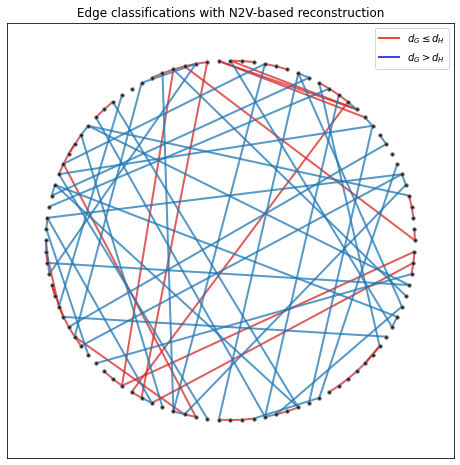

In [40]:
plt.figure(figsize=(8,8))

pos = nx.circular_layout(G)  # layout - non-boundary edges are from H (likely)

# Plotting nodes
options = {"edgecolors": "tab:gray", "node_size": 12, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=range(N), node_color="black", **options)

# Plotting edges
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if d[0] <= d[1]
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if d[0] > d[1]
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:blue",
)

# Custom legend
lines_ = [
    Line2D([0], [0], color="red", lw=2, alpha=0.75),
    Line2D([0], [0], color="blue", lw=2, alpha=0.75),
]
labels_ = [
    "$d_G \\leq d_H$",
    "$d_G > d_H$"
]
plt.legend(lines_, labels_)

plt.title("Edge classifications with N2V-based reconstruction")

plt.savefig("../../results/plots/graph_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

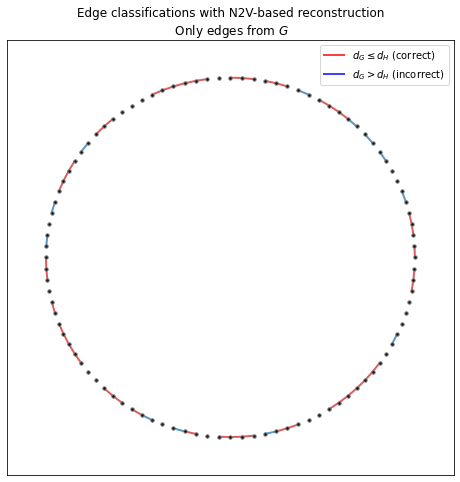

In [41]:
plt.figure(figsize=(8,8))

pos = nx.circular_layout(G)  # layout - non-boundary edges are from H (likely)

# Plotting nodes
options = {"edgecolors": "tab:gray", "node_size": 12, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=range(N), node_color="black", **options)

# Plotting edges
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if (d[0] <= d[1]) & (A[edge] == 1 if edge in A else A[edge[::-1]] == 1)
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if (d[0] > d[1]) & (A[edge] == 1 if edge in A else A[edge[::-1]] == 1)
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:blue",
)

# Custom legend
lines_ = [
    Line2D([0], [0], color="red", lw=2, alpha=0.75),
    Line2D([0], [0], color="blue", lw=2, alpha=0.75),
]
labels_ = [
    "$d_G \\leq d_H$ (correct)",
    "$d_G > d_H$ (incorrect)"
]
plt.legend(lines_, labels_)

plt.title("Edge classifications with N2V-based reconstruction\n Only edges from $G$")

plt.savefig("../../results/plots/graph-G_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

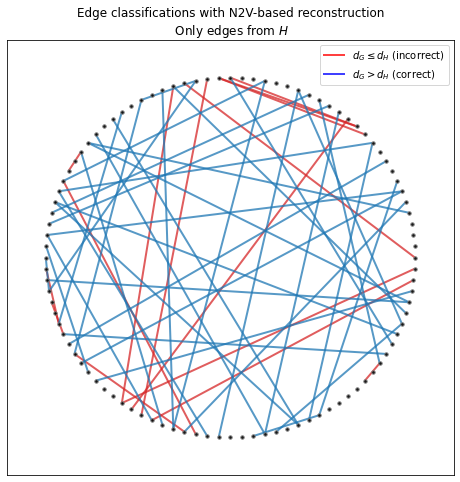

In [42]:
plt.figure(figsize=(8,8))

pos = nx.circular_layout(G)  # layout - non-boundary edges are from H (likely)

# Plotting nodes
options = {"edgecolors": "tab:gray", "node_size": 12, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=range(N), node_color="black", **options)

# Plotting edges
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if (d[0] <= d[1]) & (A[edge] == 0)
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[
        edge
        for edge, d in distances_single.items()
        if (d[0] > d[1]) & (A[edge] == 0)
    ],
    width=2,
    alpha=0.75,
    edge_color="tab:blue",
)

# Custom legend
lines_ = [
    Line2D([0], [0], color="red", lw=2, alpha=0.75),
    Line2D([0], [0], color="blue", lw=2, alpha=0.75),
]
labels_ = [
    "$d_G \\leq d_H$ (incorrect)",
    "$d_G > d_H$ (correct)"
]
plt.legend(lines_, labels_) #, loc="upper right")

plt.title("Edge classifications with N2V-based reconstruction\n Only edges from $H$")

plt.savefig("../../results/plots/graph-H_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

#### Distance

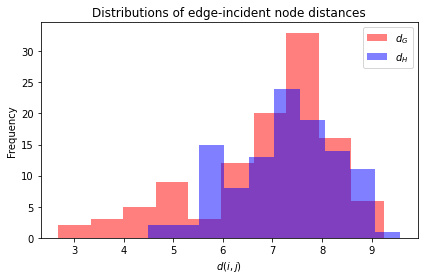

In [28]:
plt.figure()

plt.hist(d_G, label="$d_G$", color="red", alpha=0.5)
plt.hist(d_H, label="$d_H$", color="blue", alpha=0.5)

plt.legend()

plt.xlabel("$d(i,j)$")
plt.ylabel("Frequency")
plt.title("Distributions of edge-incident node distances")

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

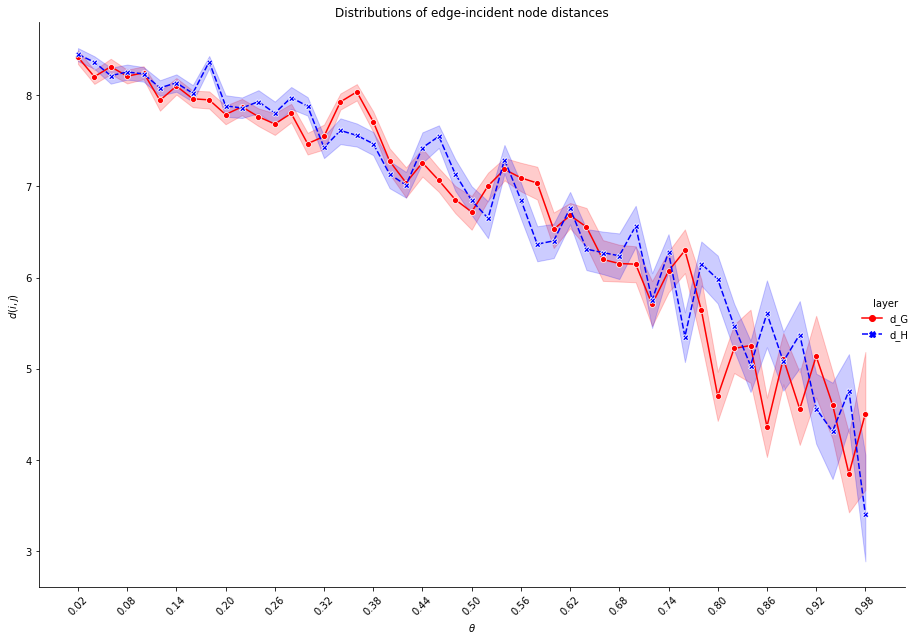

In [43]:
plt.figure()

sns.relplot(
    data=df_melted, kind="line",
    x="theta", y="distance",
    hue="layer", palette=["red", "blue"],
    style="layer",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("$\\theta$")
plt.ylabel("$d(i,j)$")
plt.title("Distributions of edge-incident node distances")

plt.xticks(thetas[::3], rotation=45)

plt.tight_layout()

plt.savefig("../../results/plots/line_distances_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

<Figure size 432x288 with 0 Axes>

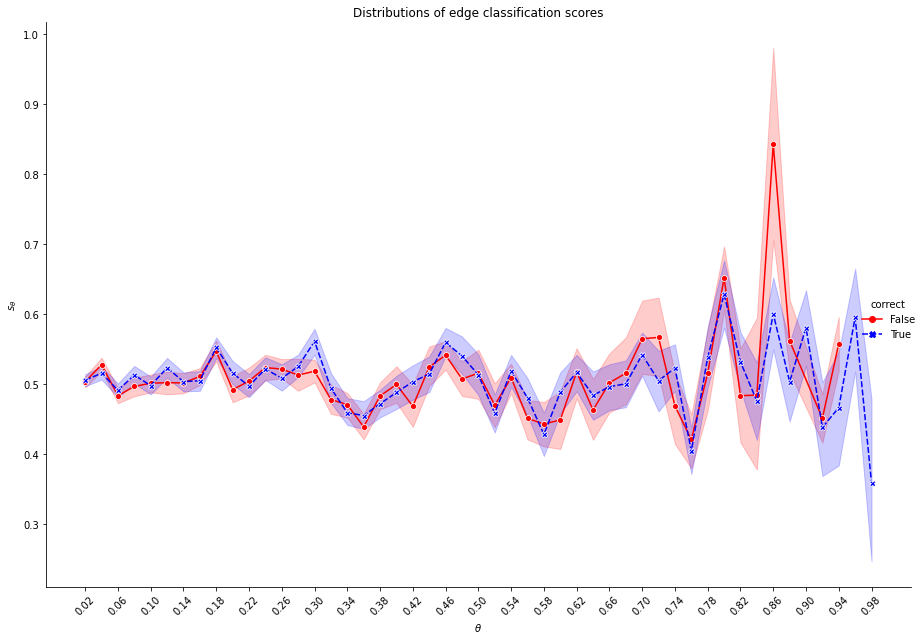

In [44]:
plt.figure()

sns.relplot(
    data=df_melted, kind="line",
    x="theta", y="score",
    hue="correct", palette=["red", "blue"],
    style="correct",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("$\\theta$")
plt.ylabel("$s_{\\theta}$")
plt.title("Distributions of edge classification scores")

plt.xticks(thetas[::2], rotation=45)

plt.tight_layout()

plt.savefig("../../results/plots/line_scores-inverse_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

<Figure size 432x288 with 0 Axes>

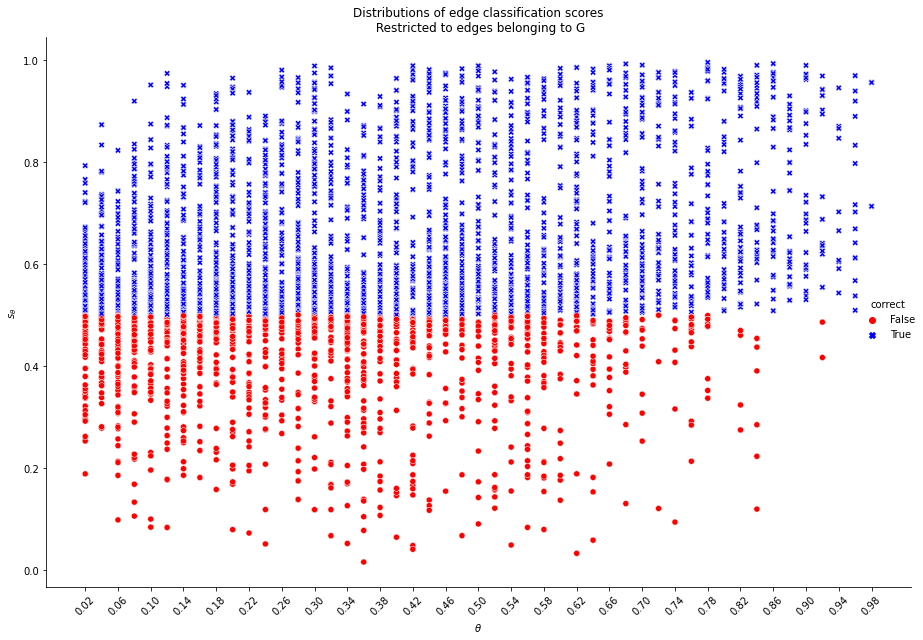

In [31]:
plt.figure()

sns.relplot(
    data=df_melted.query("ground_truth_aprx == 1"), kind="scatter",
    x="theta", y="score",
    hue="correct", palette=["red", "blue"],
    style="correct",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("$\\theta$")
plt.ylabel("$s_{\\theta}$")
plt.title("Distributions of edge classification scores\n Restricted to edges belonging to G")

plt.xticks(thetas[::2], rotation=45)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

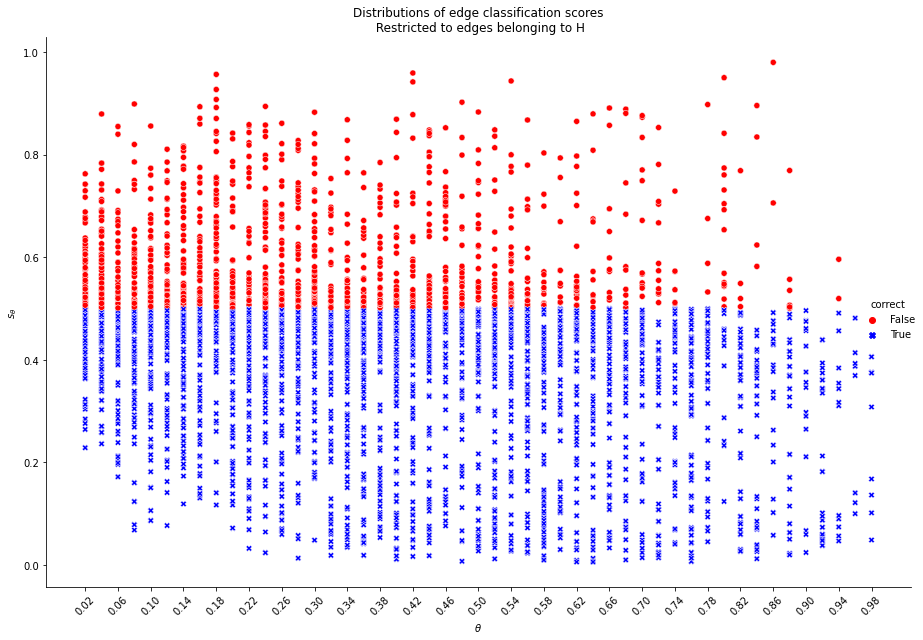

In [32]:
plt.figure()

sns.relplot(
    data=df_melted.query("ground_truth_aprx == 0"), kind="scatter",
    x="theta", y="score",
    hue="correct", palette=["red", "blue"],
    style="correct",
    markers=True,
    height=9, aspect=12/9
)

plt.xlabel("$\\theta$")
plt.ylabel("$s_{\\theta}$")
plt.title("Distributions of edge classification scores\n Restricted to edges belonging to H")

plt.xticks(thetas[::2], rotation=45)

plt.tight_layout()

#### Accuracy

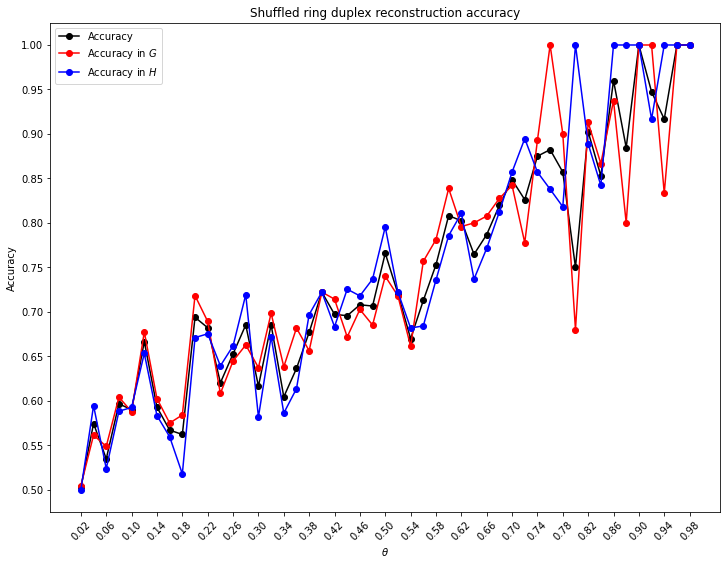

In [45]:
plt.figure(figsize=(12,9))

df.groupby("theta")["correct"].mean().plot(marker="o", color="black", label="Accuracy")
df.loc[df["classification"]==1].groupby("theta")["correct"].mean().plot(marker="o", color="red", label="Accuracy in $G$")
df.loc[df["classification"]==0].groupby("theta")["correct"].mean().plot(marker="o", color="blue", label="Accuracy in $H$")

plt.legend()

plt.xticks(thetas[::2], rotation=45)
plt.yticks(np.arange(0.5, 1.05, 0.05))

plt.xlabel("$\\theta$")
plt.ylabel("Accuracy")
plt.title("Shuffled ring duplex reconstruction accuracy")

plt.savefig("../../results/plots/line_accuracy_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)

Text(0.5, 1.0, 'Misclassification probability')

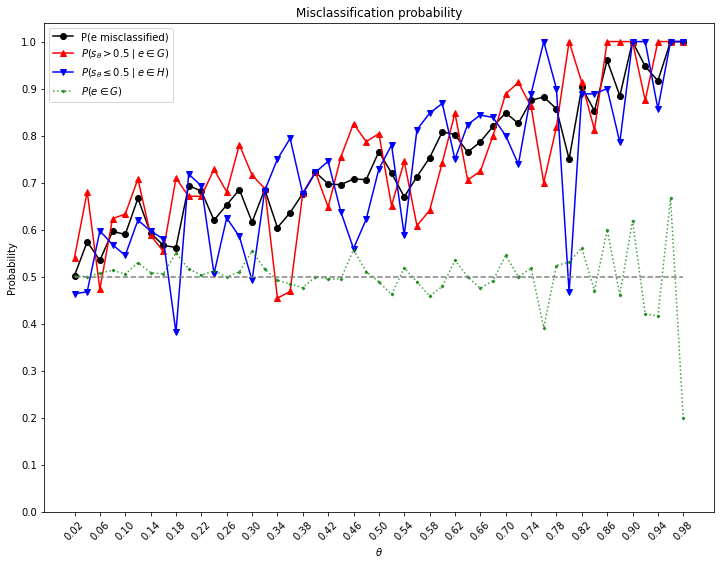

In [34]:
plt.figure(figsize=(12,9))

plt.plot(thetas, ps_misclass, label = "P(e misclassified)", color="black", marker="o")
plt.plot(thetas, ps_misclass_G, label = "$P(s_{\\theta} > 0.5 \\mid e \\in G)$", color="red", marker="^")
plt.plot(thetas, ps_misclass_H, label = "$P(s_{\\theta} \\leq 0.5 \\mid e \\in H)$", color="blue", marker="v")

plt.plot(thetas, ps_G, label="$P(e \\in G)$", color="green", marker="D", linestyle=":", alpha=0.75, markersize=2)
plt.plot(thetas, [0.5]*len(thetas), color="gray", linestyle="--")

plt.legend()

plt.xticks(thetas[::2], rotation=45)
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlabel("$\\theta$")
plt.ylabel("Probability")
plt.title("Misclassification probability")

Text(0.5, 1.0, 'Misclassification probability\n Rolling average with neighborhood 4')

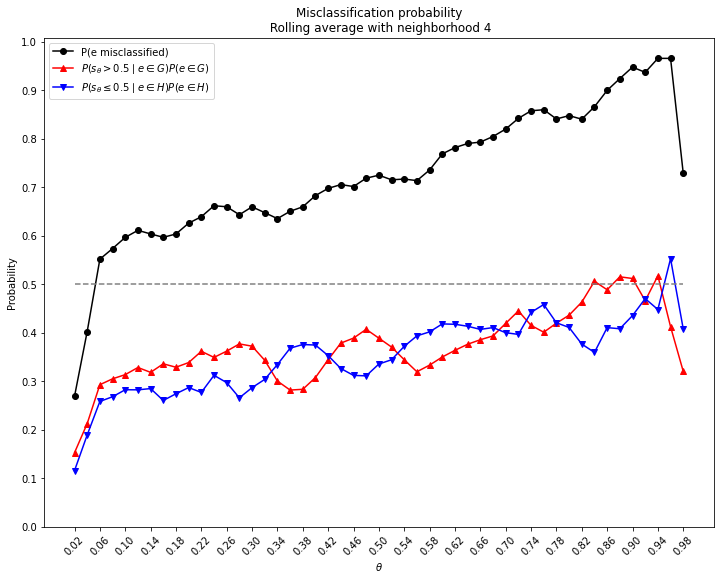

In [35]:
plt.figure(figsize=(12,9))

window_resolution = 4
window = [1/window_resolution] * window_resolution

plt.plot(thetas, np.convolve(ps_misclass, window, mode="same"), label = "P(e misclassified)", color="black", marker="o")
plt.plot(thetas, np.convolve([ps_misclass_G[idx]*ps_G[idx] for idx in range(len(thetas))], window, mode="same"), label = "$P(s_{\\theta} > 0.5 \\mid e \\in G)P(e \\in G)$", color="red", marker="^")
plt.plot(thetas, np.convolve([ps_misclass_H[idx]*ps_H[idx] for idx in range(len(thetas))], window, mode="same"), label = "$P(s_{\\theta} \\leq 0.5 \\mid e \\in H)P(e \\in H)$", color="blue", marker="v")
plt.plot(thetas, [0.5]*len(thetas), color="gray", linestyle="--")

plt.legend()

plt.xticks(thetas[::2], rotation=45)
plt.yticks(np.arange(0.0, 1.1, 0.1))

plt.xlabel("$\\theta$")
plt.ylabel("Probability")
plt.title(f"Misclassification probability\n Rolling average with neighborhood {window_resolution}")

# plt.text(0, 0.95, "Watchout for boundary effects! Convolution mode is 'same'", color="black", size=12)

In [36]:
df_misclassified = df_melted.query("correct == False")  # Conditioning on misclassification
df_misclassified = df_misclassified.query("likelihood_metric == 'inverse'")  # only caring about inverse metric scores

In [37]:
p_G_misclass = len(df_misclassified.query("ground_truth_aprx == 1")) / len(df_misclassified)
p_H_misclass = 1 - p_G_misclass

print(f"P(e in G | e misclassified) = {p_G_misclass:.4f}")

P(e in G | e misclassified) = 0.4839


In [38]:
ps = []
for theta_ in thetas:
    df_ = df_misclassified.query("theta == @theta_")
    if len(df_) > 0:
        p_G_misclass = len(df_.query("ground_truth_aprx == 1")) / len(df_)
    else:
        p_G_misclass = 0
        #print(f"theta = {theta_:.2f} ==> P(e in G | e misclassified) = {p_G_misclass:.4f}")
    ps.append(p_G_misclass)

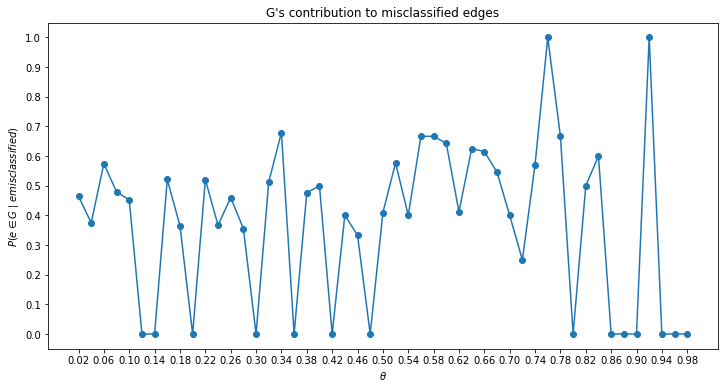

In [52]:
plt.figure(figsize=(12,6))

plt.plot(thetas, ps, marker="o")

plt.xticks(thetas[::2])
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel("$\\theta$")
plt.ylabel("$P(e \\in G \\mid e misclassified)$")
plt.title("G's contribution to misclassified edges")

plt.savefig("../../results/plots/line_misclassfied-by-layer_EMB_ex14v1.2.1_DK_20230104.png", facecolor="white", transparent=False)